## Divergence of L1-penalized logistic regression fits via Fisher Scoring

### Quick background

Fisher scoring corresponds to applying Newton's method on the L1-penalized logistic regression maximum likelihood objective.

It is well known that fitting a logistic regression model on a perfectly separable dataset leads to diverging solution coefficients.

This divergence case can be easily dealt with by "clipping" the logistic function.

However, _and even with clipping_, some problematic datasets can lead to diverging solution from the Fisher scoring optimization procedure as we decrease the L1 regularization penalty.

The reason?
- It is well known that Newton's method diverges if the starting point is too far from the optimum.
- On some bad datasets like below, the starting point "optimal beta solution at $\lambda_0$" can be very far (and a diverging Newton starting point) if we look for "optimal beta solution at $\lambda_1$", for  $\lambda_0 > \lambda_1$.

### Typical divergence edge case: "disagreeing" features

Picture a dataset (y, X) where y is length-n binary vector of observations that we want to fit via L1-penalized logistic regression, and X is a (n, p + 1) shaped features matrix where each feature is also binary. No intercept for X.

We say that a binary feature j, for j in (1, ..., p+1) is "activated" on row i if X_i,j = 1.

We assume that:
1. For some number n_1 of rows, all features are activated and y = 0.0
2. For some number n_2 >> n_1 of rows, feature 2 is activated, all others are not and y = 1.0.
3. For some number n_2 >> n_1 of rows, feature 3 is activated, all others are not and y = 1.0.
... and so on.

In this case, with no L1-penalty $\lambda$ and a "clipped" logistic function, the optimal beta (of length p + 1), is something like:
- beta_1, ..., beta_p = b1. With b1 a large positive number.
- beta_0 = b0. With b0 a large _negative_ number, and |b0| large compared to p * |b1| 

However, when the L1-penalty $\lambda$ is "large", since n_2 >> n_1, the optimal beta is:
- beta_1, ..., beta_p = b1_tilde. With b1_tilde a positive number and b1_tilde < b1.
- beta_0 = 0.0.


Consequently, and as we will se numerically below:

- If we start from beta_tilde optimal solution for some regularization $\lambda_0$, where beta_0_tilde = 0.0 (first feature _not yet_ in the model).
- If we want from beta_tilde to find beta, where beta is the optimal solution for some lower regularization $\lambda_1 < \lambda_0$ where beta_0 < 0.0 (first feature _in_ the model)
- Fisher scoring diverges because beta and beta_tilde are too far away from each other!

### Import packages and some short custom methods

In [1]:
from model_fitting import get_beta, get_w_z, compute_quadratic_loss, compute_logistic_loss
from generate_df import disagreement_df

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

###  Parameters for our nasty edge case

In [3]:
BLOCK_PROBA = 1.0
BLOCK_SIZE = 10
VOTERS = 50
X, y = disagreement_df(n_features=VOTERS, block_size=BLOCK_SIZE, block_proba=BLOCK_PROBA)

### Quick and dirty lasso path for the coefficients on this mean dataset
beta_0 very quickly climbs to very large negative values for small regularization lambda!
beta_1 is a moderately large positive number for most lambdas.

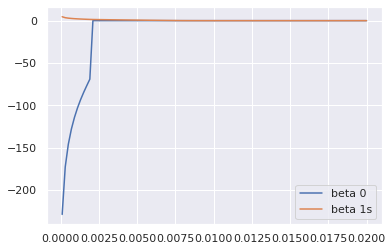

In [4]:
lambdas = np.linspace(0.0001, 0.02, num=100)
beta_0s = [get_beta(X=X, y=y, lamb=lamb, warm_beta=None)[0] for lamb in lambdas]
beta_1s = [get_beta(X=X, y=y, lamb=lamb, warm_beta=None)[1] for lamb in lambdas]
plt.figure()
plt.plot(lambdas, beta_0s, label="beta 0")
plt.plot(lambdas, beta_1s, label="beta 1s")
plt.legend()
plt.show()
plt.close()

#### Starting point: solution at $\lambda_0$ just before Beta0 enters the model:
Just before the first feature enters the model, b1 is a moderately large positive number, b0 = 0.0.

In [5]:
beta_init = get_beta(X=X, y=y, lamb=0.0026, warm_beta=None)
beta_init[0], beta_init[1]

(0.0, 1.2215715796746394)

#### Quadratic approximation at this starting point

In [6]:
w, z = get_w_z(X=X, y=y, beta=beta_init)

#### Quick and dirty viz of the optimization landscape from the quadratic approximation
For smaller regularization $\lambda_1$ where the first feature will enter the model. 

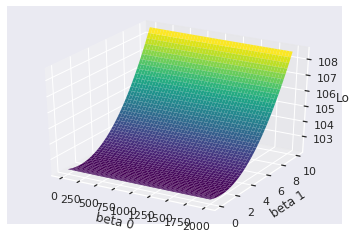

In [7]:
beta_0_ax = np.linspace(0.0, 2000.0, num=50)
beta_1_ax = np.linspace(0.0, 10.0, num=50)

losses = np.zeros((beta_0_ax.shape[0], beta_0_ax.shape[0]))
for ix, beta_0 in enumerate(beta_0_ax):
    for iy, beta_1 in enumerate(beta_1_ax):
        beta_val = np.ones(beta_init.shape[0]) * beta_1
        beta_val[0] = - beta_0
        loss = compute_quadratic_loss(X=X, z=z, w=w, beta=beta_val, lamb=0.0020)
        losses[ix, iy] = loss

xx, yy = np.meshgrid(beta_0_ax, beta_1_ax, indexing='ij')

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, losses, cmap='viridis',linewidth=0)
ax.set_xlabel('beta 0')
ax.set_ylabel('beta 1')
ax.set_zlabel('Loss')
plt.show()

#### Optimal Beta found via this quadratic approximation: super large value for beta_0!!
Newton descent is diverging...

In [8]:
a, b = np.unravel_index(losses.argmin(), losses.shape)
beta_0_ax[a], beta_1_ax[b]

(1795.9183673469388, 1.4285714285714286)

#### Quick and dirty visualization of the actual optimization landscape (logistic loss + L1 penalty)
For smaller regularization $\lambda_1$ where the first feature will enter the model. 

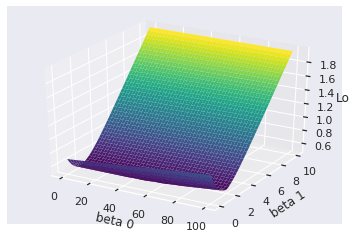

In [9]:
beta_0_ax = np.linspace(0.0, 100.0, num=50)
beta_1_ax = np.linspace(0.0, 10.0, num=50)

losses = np.zeros((beta_0_ax.shape[0], beta_0_ax.shape[0]))
for ix, beta_0 in enumerate(beta_0_ax):
    for iy, beta_1 in enumerate(beta_1_ax):
        beta_val = np.ones(beta_init.shape[0]) * beta_1
        beta_val[0] = - beta_0
        losses[ix, iy] = compute_logistic_loss(X=X, y=y, beta=beta_val, lamb=0.0020)

xx, yy = np.meshgrid(beta_0_ax, beta_1_ax, indexing='ij')

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, losses,cmap='viridis',linewidth=0)
ax.set_xlabel('beta 0')
ax.set_ylabel('beta 1')
ax.set_zlabel('Loss')
plt.show()

#### Optimal Beta for the actual loss function:  the optimal beta_0 if actually far from being as large...
We will never converge to this optimal solution (even if it is finite and not that large), via Newton descent

In [10]:
a, b = np.unravel_index(losses.argmin(), losses.shape)

beta_0_ax[a], beta_1_ax[b]

(65.3061224489796, 1.4285714285714286)